# Association Rule Project

**Goal**: The objective of this project is to identify the pattern in which different characters are associated to each other in a TV show (or even a movie). The methodology is to collect script data and using that identify the characters present in each scene. Once such data is curated we apply association rules to identify how charcaters are related to each other. 

The idea is, after applying association rules we will be able to identify which characters are assocaited with each other, and how (antecedents or consequents).

Let's get started!

In [28]:
# Importing all required libraries
import os
import kagglehub
import pandas as pd
import re
from itertools import combinations
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import seaborn as sns


## We will use a dataset for Friends TV show

In [12]:

# Downloading the dataset
path = kagglehub.dataset_download("blessondensil294/friends-tv-series-screenplay-script")

print("Path to dataset files:", path)


Path to dataset files: /Users/rajat/.cache/kagglehub/datasets/blessondensil294/friends-tv-series-screenplay-script/versions/1


In [13]:
#print one sample file

k = open(os.path.join(path, "S09E17 The Memorial Service.txt"), 'r', encoding='utf-8')
sample_file = k.read()

print(sample_file)



Friends
917 - The One With The Memorial Service


Story by: Robert Carlock
Directed by: Gary Halvorson

[Scene: Ross' apartment , Chandler and Joey enter]

Chandler: Hey! Ready to go?

Ross: Oh yeah, let me just finish this.

Joey: Hey Ross, check this out! (he tries to spin a basketball on his fingertip but he throws it against a table) yeah, I can't do that!

Chandler: What are you doin'?

Ross: Have you seen this? It's a new alumni website for college! It's cool! You can post messages for people, let everyone know what you're up to.

Chandler: Great, a faster way to tell people that I'm unemployed and childless .

Ross: It's actually kinda interesting to find out what people are doing... remember Andrea Rich?

Chandler: The tall girl who wouldn't sleep with you?

Ross: Uh uh... well, her Internet Company went under and she lost an ear in a boating accident...

Chandler: Bet she'd sleep with you now...

Ross: No... I already e-mailed her.

Chandler: Let me see what you wrote about yo

## This is text data, we will do data pre processing to create a strctured input for the association rule mining. 

### We will assume a charcaters presence based on dialogue. The best case scenario would be if we can get screen presence data, which tracks actors presence on screen based on timestamp (I'm working on it as an image recognition side project :))

### However in this case, we use the dialogue data to identify presence of characters, which is fairly accurate representation, and the script text files are easy to access. 

In [14]:

# List all text files
script_files = [f for f in os.listdir(path) if f.endswith('.txt')]

# Regular expression patterns for scenes and actors
scene_pattern = r"\[Scene: (.*?)\]"
actor_pattern = r"([A-Z][a-z]+):"  # Only capture words starting with capital letter followed by lowercase letters

# List to store scene and actor data
scene_data = []
all_actors = set()

# Process each script file
for script_file in script_files:
    with open(os.path.join(path, script_file), 'r', encoding='utf-8') as file:
        script_text = file.read()

        # Split script into scenes by looking for [Scene: ]
        scenes = script_text.split('[Scene:')

        # Process each scene
        for i, scene in enumerate(scenes[1:], start=1):
            scene_info = {}
            scene_info['scene_number'] = i
            scene_info['script_file'] = script_file  # To identify which script the scene belongs to

            # Extract actors from the scene
            actors = re.findall(actor_pattern, scene)
            scene_info['actors'] = actors

            # Update all_actors set to keep track of unique actor names
            all_actors.update(actors)

            scene_data.append(scene_info)

# Create a DataFrame
all_actors = sorted(list(all_actors))  # Sort actors to maintain consistent column order

# Create a matrix for the scene data
scene_matrix = []

for scene_info in scene_data:
    scene_row = [scene_info['scene_number'], scene_info['script_file']]
    
    # For each actor, mark if they are present in the scene
    for actor in all_actors:
        scene_row.append(1 if actor in scene_info['actors'] else 0)
    
    scene_matrix.append(scene_row)

# Create pandas DataFrame
df = pd.DataFrame(scene_matrix, columns=['scene_number', 'script_file'] + all_actors)

#  Display the DataFrame
print(df.head())  # Show the first few rows to verify the result




   scene_number                      script_file  Actor  Adrienne  Agent  \
0             1  S09E17 The Memorial Service.txt      0         0      0   
1             2  S09E17 The Memorial Service.txt      0         0      0   
2             3  S09E17 The Memorial Service.txt      0         0      0   
3             4  S09E17 The Memorial Service.txt      0         0      0   
4             5  S09E17 The Memorial Service.txt      0         0      0   

   Alan  Alex  Alexander  Alice  All  ...  Williams  Witch  Woman  Worker  \
0     0     0          0      0    0  ...         0      0      0       0   
1     0     0          0      0    0  ...         0      0      0       0   
2     0     0          0      0    0  ...         0      0      0       0   
3     0     0          0      0    0  ...         0      0      0       0   
4     0     0          0      0    0  ...         0      0      0       0   

   Writer  Zack  Zane  Zellner  Zelner  Zoe  
0       0     0     0        0    

## In the above Dataframe, we have a column for scene number, script file and a column for each characters name. 1 represent the character was in the scene, and 0 reflects non presence. 

### Scene is identified from the script and is enumerated to create a uniqye identifier for each scene. 

### Now, we will do some data cleaning and filtering to keep data more relevant for Association rule mining


### As part of filtering we will keep actors who appear more than 100 times, the rest are not so interesting as their are a lot of characters who are guests or come to show for an episode or two. Considering we are dealing with data from friends TV show, which has 10 seasons, our main focus is on actors with at least a minimal level of dialogues. 

In [15]:
# Count how many times each actor appears across all scenes
actor_appearance_count = df.drop(['scene_number', 'script_file'], axis=1).sum()


# actors who have a dialogue more than 100 times
actors_to_keep = actor_appearance_count[actor_appearance_count > 20].index.tolist()

# Filter the DataFrame to include only the relevant actors
filtered_df = df[['scene_number', 'script_file'] + actors_to_keep]

# Display the filtered DataFrame
print(filtered_df.tail())  # Show the first few rows



      scene_number           script_file  All  Carol  Chandler  Charlie  \
3045            17  S01E23 The Birth.txt    0      1         1        0   
3046            18  S01E23 The Birth.txt    0      0         0        0   
3047            19  S01E23 The Birth.txt    1      1         1        0   
3048            20  S01E23 The Birth.txt    0      1         1        0   
3049            21  S01E23 The Birth.txt    1      0         1        0   

      Director  Emily  Geller  Gunther  ...  Mike  Monica  Nurse  Phoebe  \
3045         0      0       0        0  ...     0       1      1       0   
3046         0      0       0        0  ...     0       0      0       1   
3047         0      0       0        0  ...     0       0      1       1   
3048         0      0       0        0  ...     0       1      0       1   
3049         0      0       0        0  ...     0       1      0       1   

      Rachel  Richard  Ross  Susan  Tag  Woman  
3045       1        0     0      0    0    

In [16]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3050 entries, 0 to 3049
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   scene_number  3050 non-null   int64 
 1   script_file   3050 non-null   object
 2   All           3050 non-null   int64 
 3   Carol         3050 non-null   int64 
 4   Chandler      3050 non-null   int64 
 5   Charlie       3050 non-null   int64 
 6   Director      3050 non-null   int64 
 7   Emily         3050 non-null   int64 
 8   Geller        3050 non-null   int64 
 9   Gunther       3050 non-null   int64 
 10  Guy           3050 non-null   int64 
 11  Janice        3050 non-null   int64 
 12  Joey          3050 non-null   int64 
 13  Man           3050 non-null   int64 
 14  Mike          3050 non-null   int64 
 15  Monica        3050 non-null   int64 
 16  Nurse         3050 non-null   int64 
 17  Phoebe        3050 non-null   int64 
 18  Rachel        3050 non-null   int64 
 19  Richar

### As manual filtering, I notice some columns which are not represntative, removing these individually even if they have more than 100 dialogues

In [17]:
# Remove unwanted columns: "Director", "All", "Guy", "Woman", "Geller"
columns_to_remove = ['Director', 'All', 'Guy', 'Woman', 'Geller', 'Nurse']
filtered_df = filtered_df.drop(columns=columns_to_remove, errors='ignore')

# Display the filtered DataFrame after removing specified columns
print(filtered_df.head())  # Show the first few rows


   scene_number                      script_file  Carol  Chandler  Charlie  \
0             1  S09E17 The Memorial Service.txt      0         1        0   
1             2  S09E17 The Memorial Service.txt      0         0        0   
2             3  S09E17 The Memorial Service.txt      0         1        0   
3             4  S09E17 The Memorial Service.txt      0         0        0   
4             5  S09E17 The Memorial Service.txt      0         1        0   

   Emily  Gunther  Janice  Joey  Man  Mike  Monica  Phoebe  Rachel  Richard  \
0      0        0       0     1    0     0       0       0       0        0   
1      0        0       0     1    0     0       0       0       1        0   
2      0        0       0     0    0     0       1       1       0        0   
3      0        0       0     1    0     0       0       0       1        0   
4      0        0       0     0    0     0       1       0       0        0   

   Ross  Susan  Tag  
0     1      0    0  
1     0     

In [18]:
filtered_df.head()

,scene_number,script_file,Carol,Chandler,Charlie,Emily,Gunther,Janice,Joey,Man,Mike,Monica,Phoebe,Rachel,Richard,Ross,Susan,Tag
0,1,S09E17 The Memorial Service.txt,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,2,S09E17 The Memorial Service.txt,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,3,S09E17 The Memorial Service.txt,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0
3,4,S09E17 The Memorial Service.txt,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,5,S09E17 The Memorial Service.txt,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [19]:
# Exclude non-character columns
character_columns = filtered_df.columns.difference(['scene_number', 'script_file'])

# Count the number of dialogue occurrences per character per scene
dialogue_counts = filtered_df[character_columns].sum(axis=0)

# Sort characters by the number of lines
dialogue_counts_sorted = dialogue_counts.sort_values(ascending=False)

# Display results
print(dialogue_counts_sorted)

Chandler    1356
Joey        1316
Rachel      1314
Monica      1292
Ross        1259
Phoebe      1207
Gunther       63
Mike          60
Janice        44
Carol         38
Charlie       33
Emily         31
Man           31
Susan         27
Tag           27
Richard       23
dtype: int64


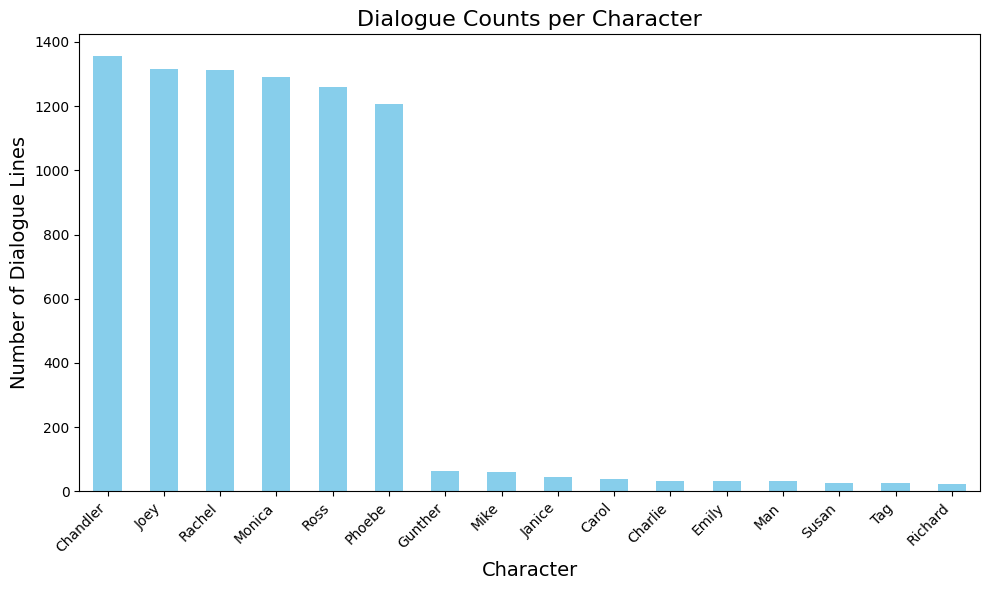

In [23]:


# Plotting the dialogue counts
plt.figure(figsize=(10, 6))
dialogue_counts_sorted.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Dialogue Counts per Character', fontsize=16)
plt.xlabel('Character', fontsize=14)
plt.ylabel('Number of Dialogue Lines', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Display the plot
plt.tight_layout()
plt.show()

### As Expected the top 6 are the lead friends characters. Chandler is leading with most dialogues throughout the friends series, Phoebe with least (among top 6). 

### Now that we have a basic intution of the data, and it seems valid based on my domain knowledge, I will proceed with finding some association rules.

In [26]:
# Drop unnecessary columns
df_transformed = filtered_df.drop(columns=['scene_number', 'script_file'])

# Ccnvert binary values (1 or 0) to boolean (True for 1, False for 0)
df_transformed = df_transformed.apply(lambda x: x == 1)

# create a list of all scenes, each scene is a list of characters who spoke
scenes = df_transformed.values.tolist()

# the co-occurrence matrix
co_occurrence = {}

# Iterate through all scenes
for scene in scenes:
    # Get all pairs of characters that appear in the scene
    pairs = combinations([i for i, x in enumerate(scene) if x], 2)  
    for pair in pairs:
        pair = tuple(sorted(pair))  # sort to avoid duplicate pairs
        if pair in co_occurrence:
            co_occurrence[pair] += 1
        else:
            co_occurrence[pair] = 1

# convert co_occurrence dictionary to a DataFrame
co_occurrence_df = pd.DataFrame(list(co_occurrence.items()), columns=['pair', 'count'])

# Show top pairs by co-occurrence count
co_occurrence_df.sort_values(by='count', ascending=False).head(10)


,pair,count
4,"(1, 9)",888
0,"(1, 6)",818
13,"(11, 13)",759
6,"(9, 10)",738
11,"(9, 11)",706
12,"(10, 11)",691
1,"(1, 13)",668
3,"(6, 11)",663
14,"(6, 9)",656
2,"(6, 13)",649


In [27]:
# Convert the scene data into transactions for the Apriori algorithm
transactions = []

for scene in scenes:
    # Get all characters who spoke in the scene
    transaction = [df_transformed.columns[i] for i, x in enumerate(scene) if x]
    transactions.append(transaction)


te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

df_te = pd.DataFrame(te_ary, columns=te.columns_)

# Apply the Apriori algorithm
frequent_itemsets = apriori(df_te, min_support=0.01, use_colnames=True)

# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Filter rules with high lift and confidence
high_lift_rules = rules[rules['lift'] > 1.5]
high_confidence_rules = rules[rules['confidence'] > 0.7]


print(high_lift_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
print(high_confidence_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


    antecedents                               consequents   support  \
0        (Ross)                                   (Carol)  0.011475   
1       (Carol)                                    (Ross)  0.011475   
4      (Janice)                                (Chandler)  0.011148   
5    (Chandler)                                  (Janice)  0.011148   
8    (Chandler)                                  (Monica)  0.291148   
..          ...                                       ...       ...   
611    (Phoebe)    (Chandler, Joey, Monica, Ross, Rachel)  0.089836   
612      (Joey)  (Chandler, Phoebe, Monica, Ross, Rachel)  0.089836   
613    (Monica)    (Chandler, Phoebe, Joey, Ross, Rachel)  0.089836   
614      (Ross)  (Chandler, Phoebe, Joey, Monica, Rachel)  0.089836   
615    (Rachel)    (Chandler, Phoebe, Joey, Monica, Ross)  0.089836   

     confidence      lift  
0      0.027800  2.231303  
1      0.921053  2.231303  
4      0.772727  1.738067  
5      0.025074  1.738067  
8      

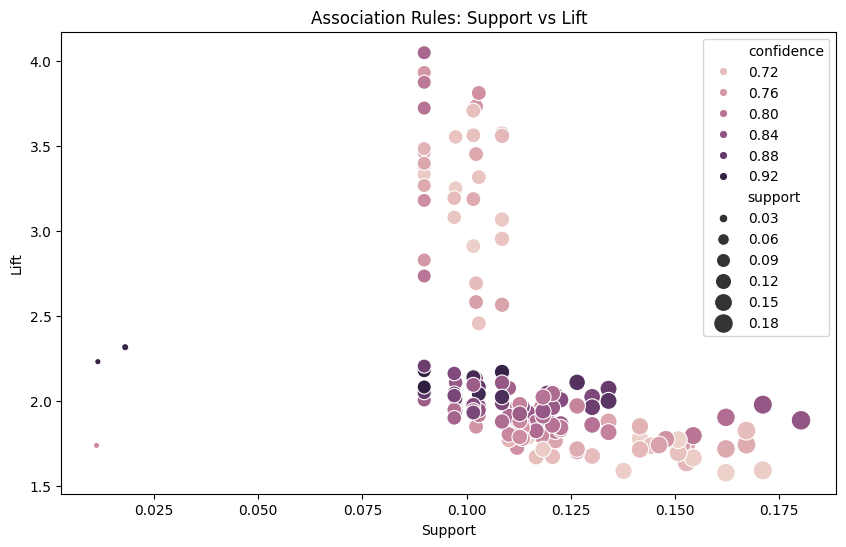

In [33]:

# Visualize the support vs. lift of the rules
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='lift', data=high_confidence_rules, hue='confidence', size='support', sizes=(20, 200))
plt.title('Association Rules: Support vs Lift')
plt.xlabel('Support')
plt.ylabel('Lift')
plt.show()


In [34]:


transactions = filtered_df.drop(['scene_number', 'script_file'], axis=1).apply(lambda x: x.index[x == 1].tolist(), axis=1).tolist()

# Use TransactionEncoder to encode the transaction data
te = TransactionEncoder()
te_ary = te.fit_transform(transactions)

# Convert to DataFrame for easier handling
trans_df = pd.DataFrame(te_ary, columns=te.columns_)

# Show summary
print(trans_df.shape)  # Prints the number of transactions and items
print(trans_df.head())  # Shows the first few rows


(3050, 16)
   Carol  Chandler  Charlie  Emily  Gunther  Janice   Joey    Man   Mike  \
0  False      True    False  False    False   False   True  False  False   
1  False     False    False  False    False   False   True  False  False   
2  False      True    False  False    False   False  False  False  False   
3  False     False    False  False    False   False   True  False  False   
4  False      True    False  False    False   False  False  False  False   

   Monica  Phoebe  Rachel  Richard   Ross  Susan    Tag  
0   False   False   False    False   True  False  False  
1   False   False    True    False  False  False  False  
2    True    True   False    False   True  False  False  
3   False   False    True    False  False  False  False  
4    True   False   False    False   True  False  False  


In [35]:
sample_df = trans_df.sample(frac=0.05, random_state=42)
print(sample_df.shape)  # Show the shape of the sample dataframe


(152, 16)


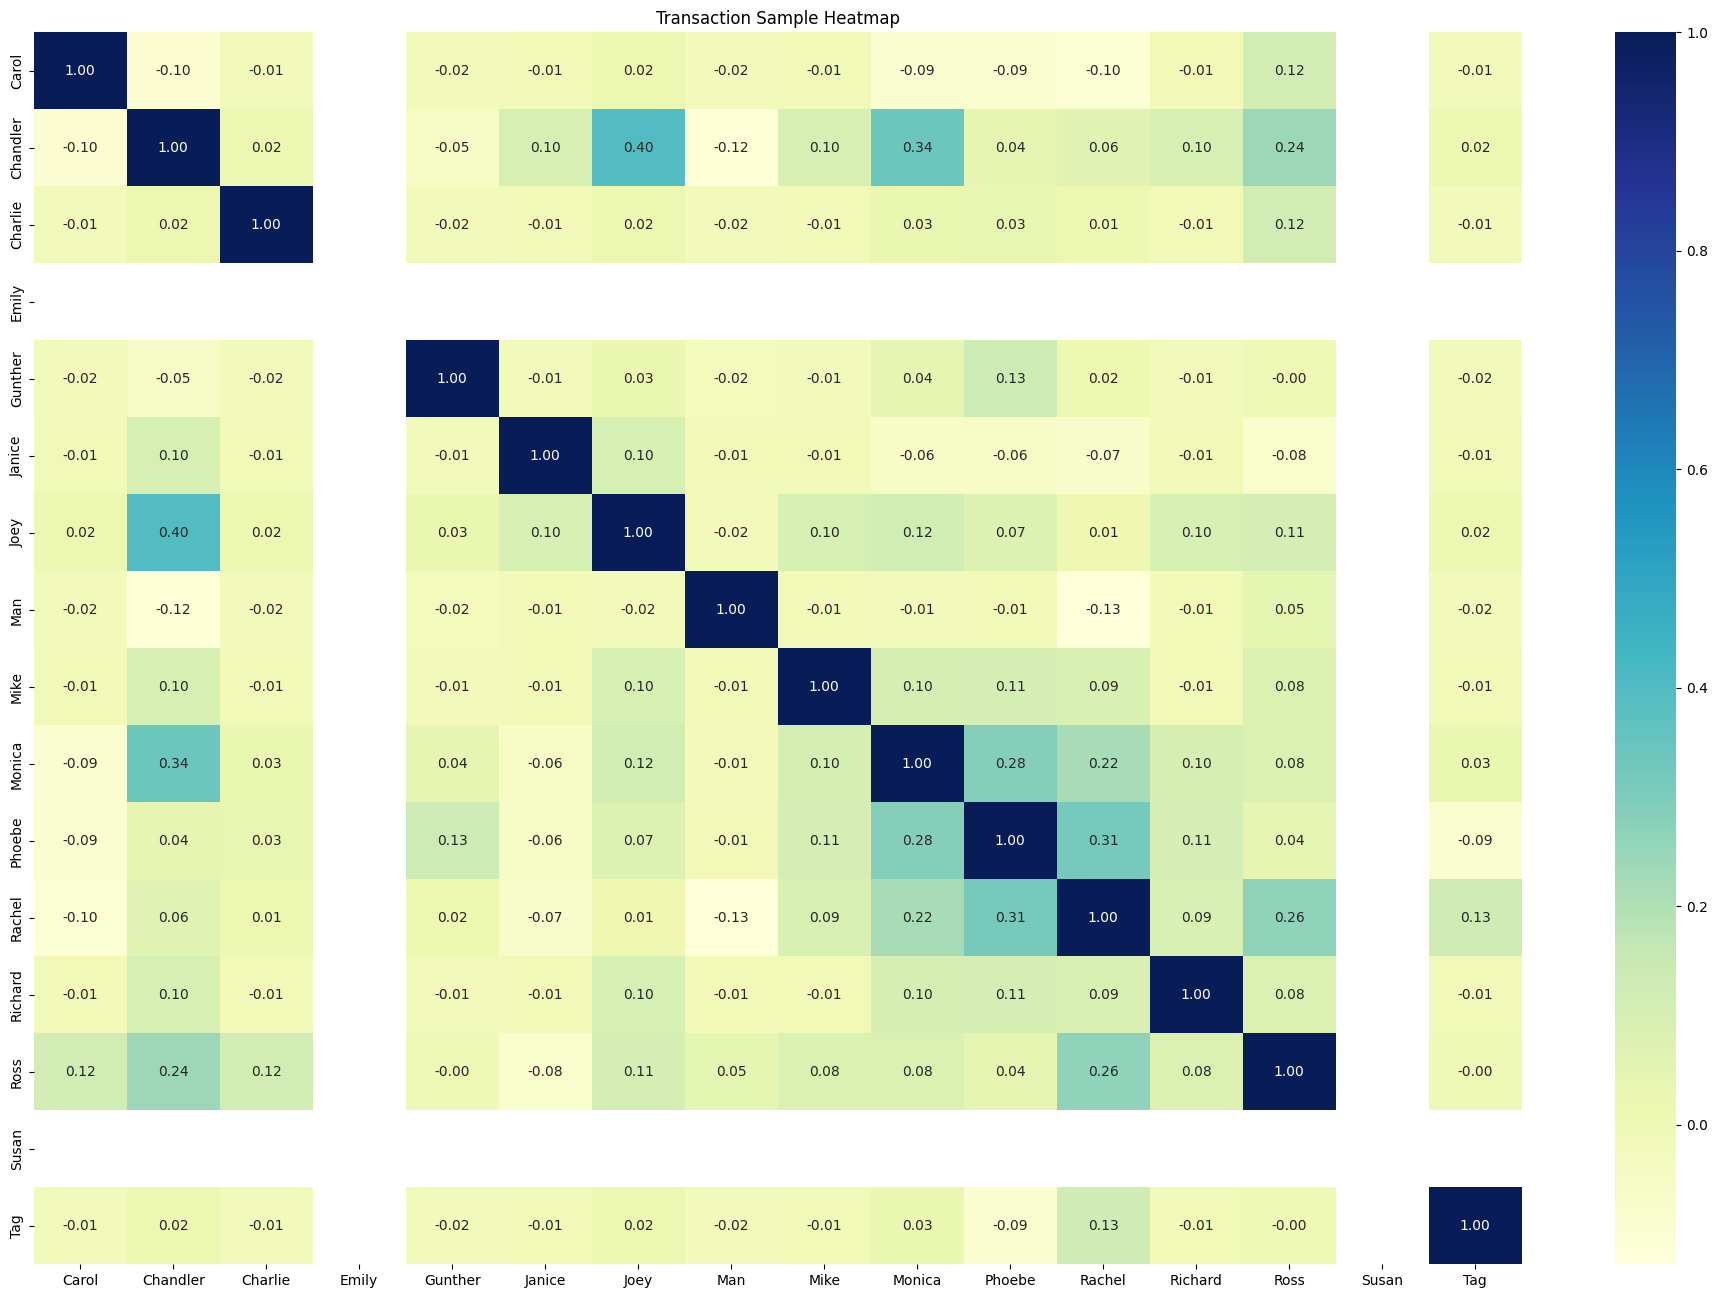

In [36]:
# Visualize the sample transaction data as a heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(sample_df.corr(), annot=True, cmap="YlGnBu", fmt='.2f')
plt.title("Transaction Sample Heatmap")
plt.show()


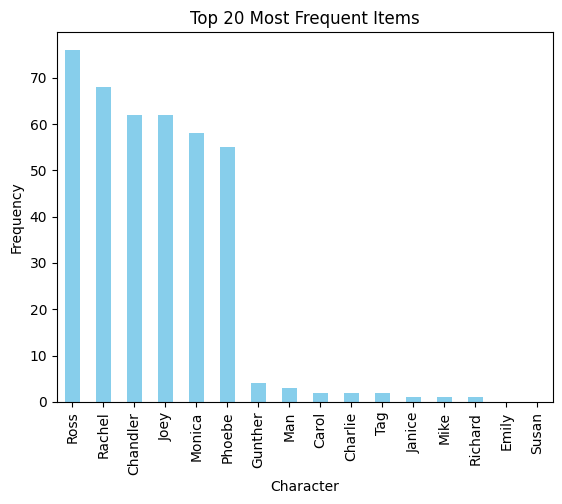

In [37]:
# Sum up the occurrences for characters
item_freq = sample_df.sum().sort_values(ascending=False)

# Plot top 20 frequent items
item_freq.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Frequent Items')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


/usr/local/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/var/folders/yb/yccw901n49qckq1d4dzj8cgh0000gn/T/ipykernel_14873/4269519966.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=itemset_sizes, palette='Blues')


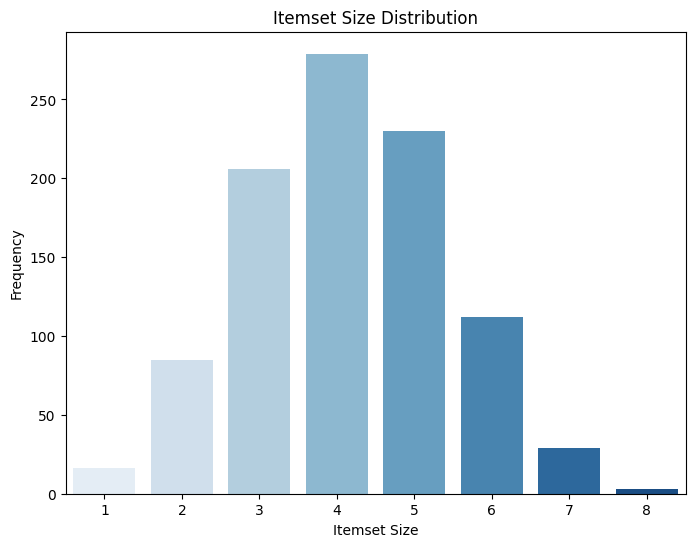

In [67]:
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt
import seaborn as sns

df_bin = filtered_df.drop(columns=['scene_number', 'script_file']).applymap(lambda x: 1 if x > 0 else 0)

# Run apriori algorithm
frequent_itemsets = apriori(df_bin, min_support=0.00008, use_colnames=True)

# Calculate the itemset sizes
itemset_sizes = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Plot the distribution of itemset sizes
plt.figure(figsize=(8, 6))
sns.countplot(x=itemset_sizes, palette='Blues')
plt.title('Itemset Size Distribution')
plt.xlabel('Itemset Size')
plt.ylabel('Frequency')
plt.show()


In [68]:
# Inspect itemsets where the size is greater than 5
large_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) > 5]
print(large_itemsets)


      support                                           itemsets
816  0.000328    (Joey, Chandler, Monica, Phoebe, Rachel, Carol)
817  0.000984      (Joey, Chandler, Monica, Phoebe, Carol, Ross)
818  0.000984     (Joey, Chandler, Monica, Phoebe, Carol, Susan)
819  0.000656      (Joey, Chandler, Monica, Rachel, Carol, Ross)
820  0.000656     (Joey, Chandler, Monica, Rachel, Carol, Susan)
..        ...                                                ...
955  0.000328  (Joey, Monica, Gunther, Phoebe, Rachel, Emily,...
956  0.000328  (Joey, Mike, Monica, Gunther, Phoebe, Rachel, ...
957  0.000328  (Joey, Chandler, Monica, Phoebe, Rachel, Carol...
958  0.000328  (Joey, Chandler, Monica, Gunther, Phoebe, Rach...
959  0.000328  (Joey, Chandler, Mike, Monica, Gunther, Phoebe...

[144 rows x 2 columns]


In [69]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apply apriori algorithm
frequent_itemsets = apriori(df_bin, min_support=0.00008, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Show the rules
print(rules)


/usr/local/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                  antecedents                                     consequents  \
0                     (Carol)                                          (Ross)   
1                     (Susan)                                         (Carol)   
2                     (Carol)                                         (Susan)   
3                   (Gunther)                                      (Chandler)   
4                    (Janice)                                      (Chandler)   
...                       ...                                             ...   
7078  (Mike, Gunther, Monica)          (Joey, Chandler, Phoebe, Rachel, Ross)   
7079  (Mike, Gunther, Phoebe)          (Joey, Chandler, Monica, Rachel, Ross)   
7080  (Mike, Gunther, Rachel)          (Joey, Chandler, Monica, Phoebe, Ross)   
7081    (Mike, Gunther, Ross)        (Joey, Chandler, Monica, Phoebe, Rachel)   
7082          (Mike, Gunther)  (Joey, Chandler, Monica, Phoebe, Rachel, Ross)   

      antecedent support  c

In [75]:
# Convert frequent_itemsets to a dictionary for quick lookups
itemsets_dict = frequent_itemsets.set_index('itemsets')['support'].to_dict()

# Add lhs_support and rhs_support to the rules
rules['lhs_support'] = rules['antecedents'].apply(lambda x: itemsets_dict.get(frozenset(x), 0))
rules['rhs_support'] = rules['consequents'].apply(lambda x: itemsets_dict.get(frozenset(x), 0))

# Subset rules
rules_sub = rules


# Calculate Kulczynski measure
rules_sub['kulczynski'] = (
    (rules_sub['support'] / rules_sub['lhs_support']) + 
    (rules_sub['support'] / rules_sub['rhs_support'])
) / 2

# Display top 5 rules by Kulczynski
top_rules = rules_sub.sort_values('kulczynski', ascending=False).head(5)
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'kulczynski']])


                          antecedents                      consequents  \
3821                    (Joey, Susan)  (Ross, Monica, Carol, Chandler)   
3803  (Ross, Monica, Carol, Chandler)                    (Joey, Susan)   
1629                    (Joey, Susan)          (Ross, Carol, Chandler)   
1625          (Ross, Carol, Chandler)                    (Joey, Susan)   
1725            (Ross, Phoebe, Carol)                (Susan, Chandler)   

       support  confidence        lift  kulczynski  
3821  0.001311    0.800000  488.000000    0.800000  
3803  0.001311    0.800000  488.000000    0.800000  
1629  0.001639    1.000000  338.888889    0.777778  
1625  0.001639    0.555556  338.888889    0.777778  
1725  0.001967    0.750000  285.937500    0.750000  


In [78]:
top_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,lhs_size,rhs_size,lhs_support,rhs_support
3821,"(Joey, Susan)","(Ross, Monica, Carol, Chandler)",0.001639,0.001639,0.001311,0.800000,488.000000,1.0,0.001309,4.991803,0.999589,0.666667,0.799672,0.800000,2,4,0.001639,0.001639
3803,"(Ross, Monica, Carol, Chandler)","(Joey, Susan)",0.001639,0.001639,0.001311,0.800000,488.000000,1.0,0.001309,4.991803,0.999589,0.666667,0.799672,0.800000,4,2,0.001639,0.001639
1629,"(Joey, Susan)","(Ross, Carol, Chandler)",0.001639,0.002951,0.001639,1.000000,338.888889,1.0,0.001635,inf,0.998686,0.555556,1.000000,0.777778,2,3,0.001639,0.002951
1625,"(Ross, Carol, Chandler)","(Joey, Susan)",0.002951,0.001639,0.001639,0.555556,338.888889,1.0,0.001635,2.246311,1.000000,0.555556,0.554826,0.777778,3,2,0.002951,0.001639
1725,"(Ross, Phoebe, Carol)","(Susan, Chandler)",0.002623,0.002623,0.001967,0.750000,285.937500,1.0,0.001960,3.989508,0.999123,0.600000,0.749343,0.750000,3,2,0.002623,0.002623


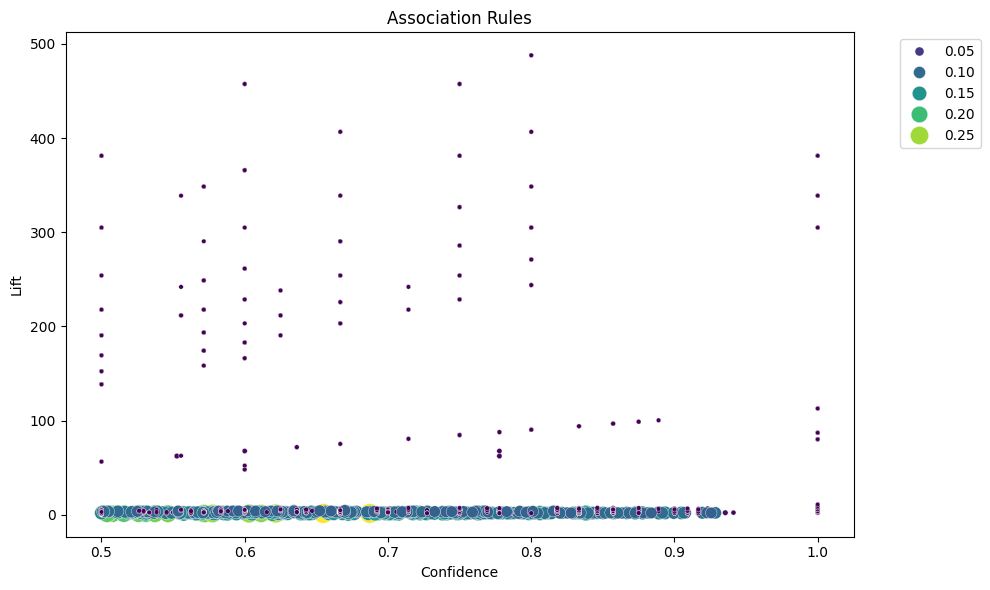

In [79]:


# Filter rules with a minimum lift value for better visualization
rules_filtered = rules[rules['lift'] > 1].copy()

# Plot lift vs confidence, sized by support
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=rules_filtered,
    x='confidence',
    y='lift',
    size='support',
    sizes=(10, 200),
    hue='support',
    palette='viridis'
)

scatter.set_title('Association Rules')
scatter.set_xlabel('Confidence')
scatter.set_ylabel('Lift')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [80]:

# Filter the top 20 rules by size
rules['rule_size'] = rules['lhs_size'] + rules['rhs_size']
top_rules = rules.nlargest(20, 'rule_size')

# Prepare data for plotting
top_rules['lhs'] = top_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
top_rules['rhs'] = top_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Parallel coordinates plot using Plotly
fig = px.parallel_coordinates(
    top_rules,
    dimensions=['lhs', 'rhs', 'support', 'confidence', 'lift'],
    color='lift',
    color_continuous_scale=px.colors.sequential.Viridis,
    title='Top 20 Rules by Size (Parallel Coordinates Plot)'
)

fig.show()
